In [1]:
# Step 1: Install Kaggle
!pip install -q kaggle

# Step 2: Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # 👈 Upload kaggle.json here

# Step 3: Move the kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the dataset
!kaggle datasets download -d muhammadusmanfarooq/pakistan-property-zameen-dataset

# Step 5: Unzip the dataset
!unzip pakistan-property-zameen-dataset.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/muhammadusmanfarooq/pakistan-property-zameen-dataset
License(s): other
Archive:  pakistan-property-zameen-dataset.zip
  inflating: zameen-updated.csv      


   property_id  location_id  \
0       237062         3325   
1       346905         3236   
2       386513          764   
3       656161          340   
4       841645         3226   

                                            page_url property_type     price  \
0  https://www.zameen.com/Property/g_10_g_10_2_gr...          Flat  10000000   
1  https://www.zameen.com/Property/e_11_2_service...          Flat   6900000   
2  https://www.zameen.com/Property/islamabad_g_15...         House  16500000   
3  https://www.zameen.com/Property/islamabad_bani...         House  43500000   
4  https://www.zameen.com/Property/dha_valley_dha...         House   7000000   

      location       city      province_name   latitude  longitude  baths  \
0         G-10  Islamabad  Islamabad Capital  33.679890  73.012640      2   
1         E-11  Islamabad  Islamabad Capital  33.700993  72.971492      3   
2         G-15  Islamabad  Islamabad Capital  33.631486  72.926559      6   
3    Bani Gala  Islamaba

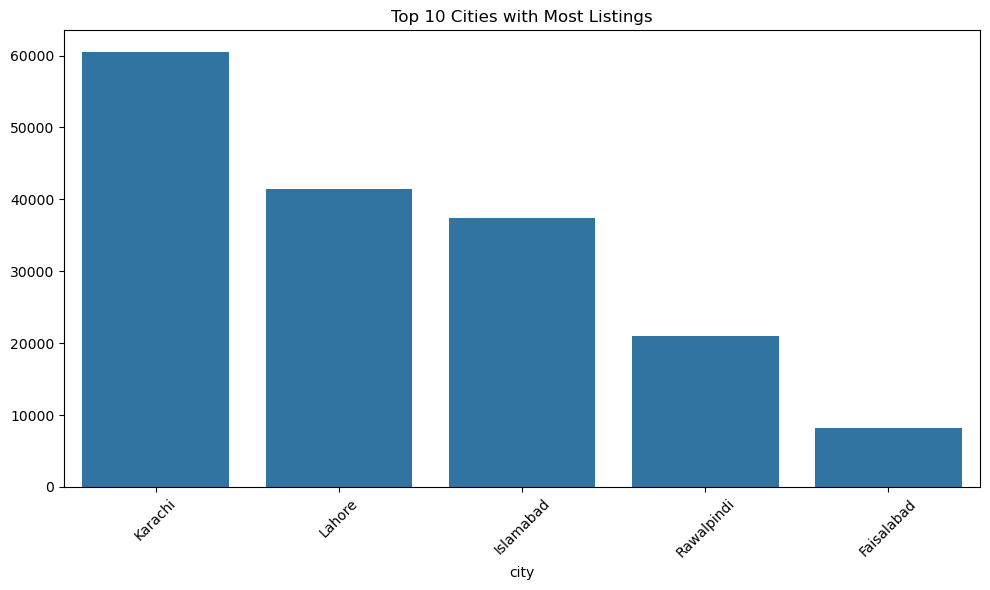

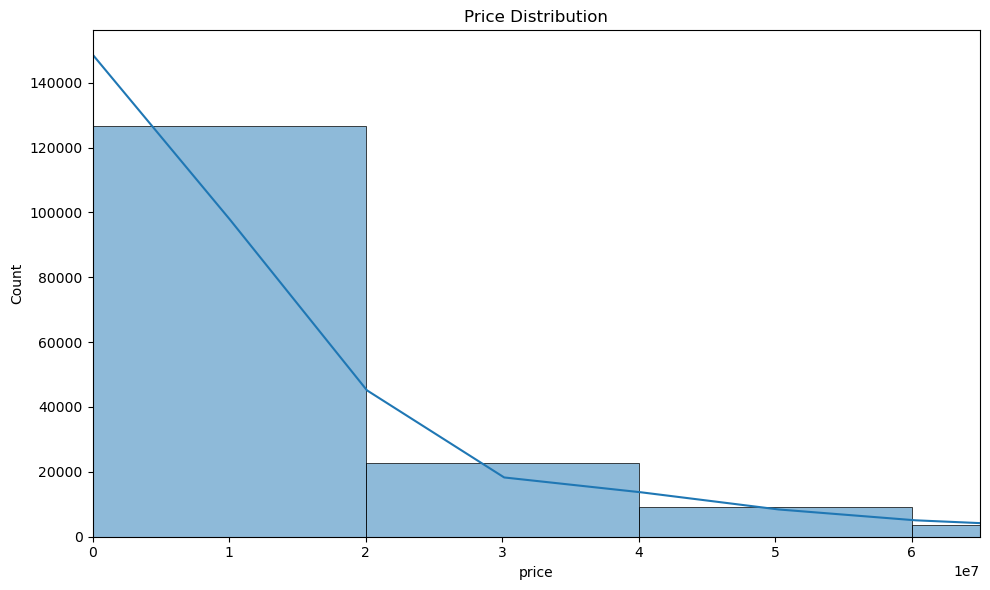

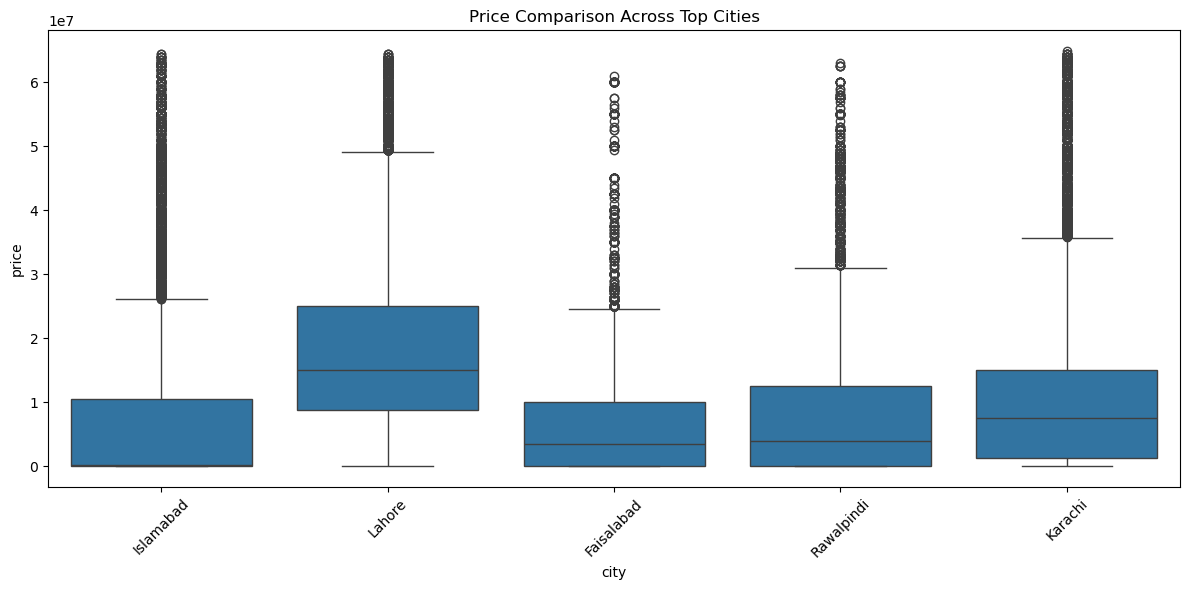

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('datasets/zameen-updated.csv')

print(df.head())
print(df.info())
print(df.describe())

top_cities = df['city'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.xticks(rotation=45)
plt.title('Top 10 Cities with Most Listings')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=100, kde=True)
plt.xlim(0, df['price'].quantile(0.95))
plt.title('Price Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
filtered_df = df[df['price'] < df['price'].quantile(0.95)]
sns.boxplot(x='city', y='price', data=filtered_df[filtered_df['city'].isin(top_cities.index)])
plt.xticks(rotation=45)
plt.title('Price Comparison Across Top Cities')
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df = pd.read_csv('datasets/zameen-updated.csv')

df = df[df['price'] > 0]
df = df[df['Area Size'] > 0]
df = df[df['bedrooms'] > 0]
df = df[df['baths'] > 0]

df = df.drop(['property_id', 'location_id', 'page_url', 'area', 'date_added', 'agency', 'agent', 'location', 'latitude', 'longitude'], axis=1)

numerical = ['Area Size', 'bedrooms', 'baths']
categorical = ['property_type', 'city', 'province_name', 'purpose', 'Area Type', 'Area Category']

X = df.drop('price', axis=1)
y = df['price']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical),
    ('cat', categorical_pipeline, categorical)
])

X_processed = preprocessor.fit_transform(X)
scaler_y = StandardScaler()
y_processed = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')


R² Score: 0.7858
Mean Absolute Error: 0.1497
Mean Squared Error: 0.2003
Root Mean Squared Error: 0.4475


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Convert sparse matrix to dense array
X_dense = X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed

X_train, X_test, y_train, y_test = train_test_split(X_dense, y_processed, test_size=0.2, random_state=42)

# Reshape for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(1, X_train.shape[1]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

y_pred = model.predict(X_test_lstm).flatten()

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')


c:\Users\huzai\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.4625 - val_loss: 0.4437
Epoch 2/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.2717 - val_loss: 0.3706
Epoch 3/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.4231 - val_loss: 0.3349
Epoch 4/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.3119 - val_loss: 0.3294
Epoch 5/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.2488 - val_loss: 0.3100
Epoch 6/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.3113 - val_loss: 0.3164
Epoch 7/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2435 - val_loss: 0.3047
Epoch 8/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2375 - val_loss: 0.3073
Epoch 9/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2415 - val_loss: 0.3135
Epoch 10/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2669 - val_loss: 0.2979
Epoch 11/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.2403 - val_loss: 0.3116
Epoch 12/20
2827/2827 ━

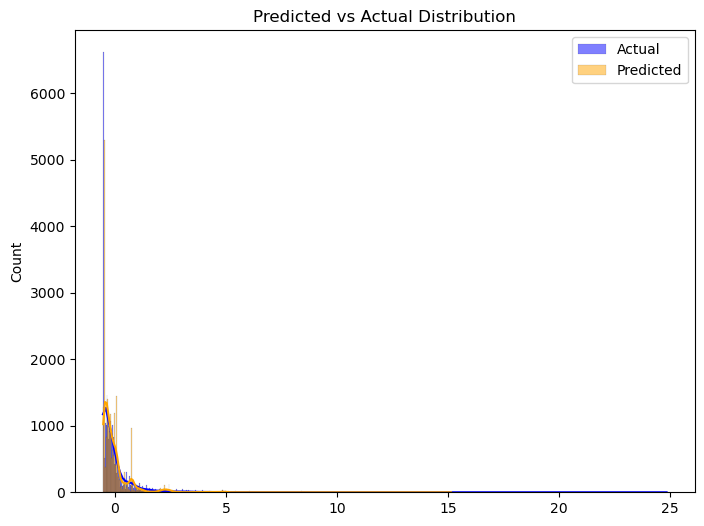

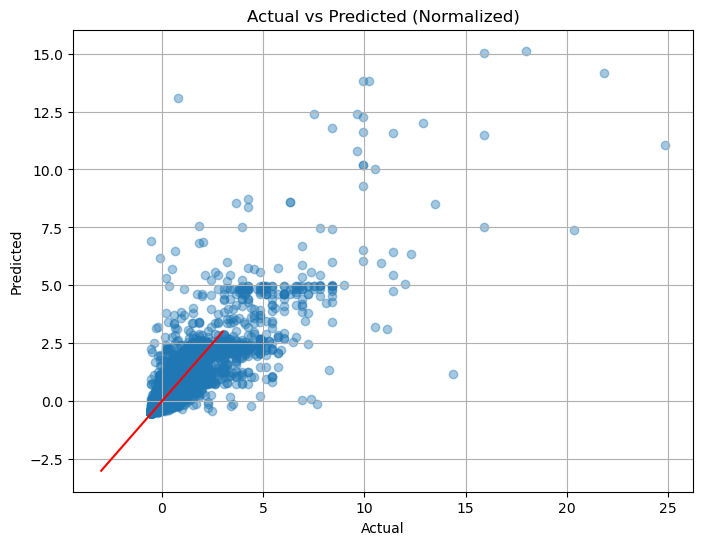

Mean Error: 0.0071
Min Error: -12.2858
Max Error: 13.7647
Std Dev of Error: 0.4543


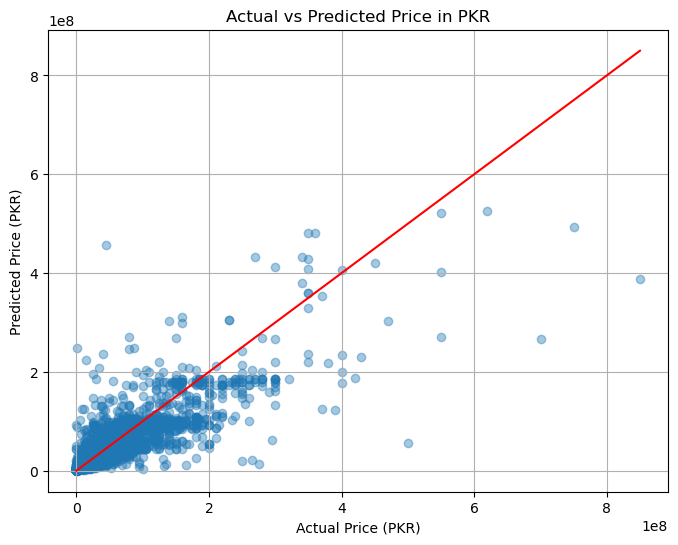

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check prediction distribution vs actual
plt.figure(figsize=(8, 6))
sns.histplot(y_test, color='blue', label='Actual', kde=True)
sns.histplot(y_pred, color='orange', label='Predicted', kde=True)
plt.legend()
plt.title('Predicted vs Actual Distribution')
plt.show()

# Scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([-3, 3], [-3, 3], color='red')  # perfect prediction line in normalized space
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Normalized)')
plt.grid(True)
plt.show()


errors = y_test - y_pred
print(f'Mean Error: {np.mean(errors):.4f}')
print(f'Min Error: {np.min(errors):.4f}')
print(f'Max Error: {np.max(errors):.4f}')
print(f'Std Dev of Error: {np.std(errors):.4f}')

# Reverse normalize y values to real PKR prices (if desired)
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_pred_real, alpha=0.4)
plt.plot([0, max(y_test_real)], [0, max(y_test_real)], color='red')
plt.xlabel('Actual Price (PKR)')
plt.ylabel('Predicted Price (PKR)')
plt.title('Actual vs Predicted Price in PKR')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

df = df.copy()


df['price'] = np.log1p(df['price'])


upper_limit = df['price'].quantile(0.99)
df = df[df['price'] < upper_limit]


X = df.drop(columns=['price'])
y = df['price']


numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)

#  Inverse log1p transform to get back to original PKR
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

print("R² Score:", r2_score(y_test_real, y_pred_real))
print("Mean Absolute Error:", mean_absolute_error(y_test_real, y_pred_real))
print("Mean Squared Error:", mean_squared_error(y_test_real, y_pred_real))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))


R² Score: 0.824977091828314
Mean Absolute Error: 4055594.170850317
Mean Squared Error: 85805950555730.86
Root Mean Squared Error: 9263150.142134741


c:\Users\huzai\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 3.7058 - mae: 0.9010 - val_loss: 0.1488 - val_mae: 0.0838 - learning_rate: 0.0010
Epoch 2/200
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.1351 - mae: 0.2000 - val_loss: 0.0125 - val_mae: 0.0558 - learning_rate: 0.0010
Epoch 3/200
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0343 - mae: 0.1335 - val_loss: 0.0059 - val_mae: 0.0406 - learning_rate: 0.0010
Epoch 4/200
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0181 - mae: 0.0981 - val_loss: 0.0034 - val_mae: 0.0325 - learning_rate: 0.0010
Epoch 5/200
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0113 - mae: 0.0783 - val_loss: 0.0055 - val_mae: 0.0559 - learning_rate: 0.0010
Epoch 6/200
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0091 - mae: 0.0689 - val_loss: 0.0035 - val_mae: 0.0352 - learning_rate: 0.0010
Epoch 7/200
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0075 - mae: 0.0618 - val_loss: 0.0028 - val_mae: 0.0297 - 

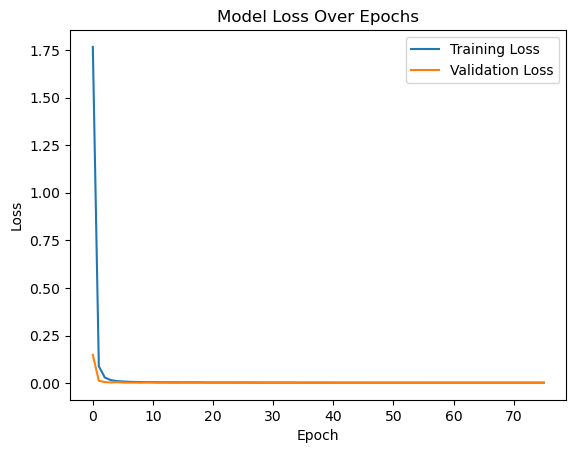

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


np.random.seed(42)
tf.random.set_seed(42)


df = df.copy()  

# Log-transform the target price
df['price'] = np.log1p(df['price'])

# Remove outliers in the log price
upper_limit = df['price'].quantile(0.99)
df = df[df['price'] < upper_limit]

X = df.drop(columns=['price'])
y = df['price']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Apply preprocessin
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


def build_model(input_dim):
    model = Sequential([
        # Input layer
        Dense(256, activation='relu', input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layers
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model


input_dim = X_train_preprocessed.shape[1]
model = build_model(input_dim)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# 11. Train the model
history = model.fit(X_train_preprocessed, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

# Predict on test set
y_pred = model.predict(X_test_preprocessed)

# 13. Inverse log1p transform to original scale
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)


r2 = r2_score(y_test_real, y_pred_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

R² Score: 0.9686
Mean Absolute Error: 0.0217
Mean Squared Error: 0.0009
Root Mean Squared Error: 0.0296


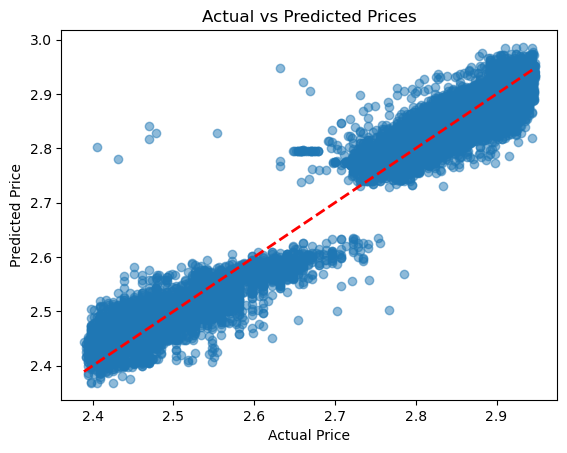

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


np.random.seed(42)

df = df.copy()


df['price'] = np.log1p(df['price'])


upper_limit = df['price'].quantile(0.975)  
lower_limit = df['price'].quantile(0.025)
df = df[(df['price'] < upper_limit) & (df['price'] > lower_limit)]


X = df.drop(columns=['price'])
y = df['price']


numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', MinMaxScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))  
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)


r2 = r2_score(y_test_real, y_pred_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


plt.scatter(y_test_real, y_pred_real, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()


Actual vs Predicted Prices (First 10 Samples):
        Actual Price  Predicted Price  Difference
113513      1.358995         1.362290   -0.003295
252         1.262530         1.254967    0.007562
17123       1.334686         1.333830    0.000856
37144       1.333345         1.337604   -0.004259
98739       1.266247         1.261074    0.005173
102126      1.264841         1.256061    0.008780
137092      1.289737         1.271779    0.017959
111855      1.343899         1.343661    0.000238
136236      1.345200         1.342512    0.002688
145872      1.338849         1.352158   -0.013310

R² Score: 0.9651

LIME Explanation for First Test Sample:


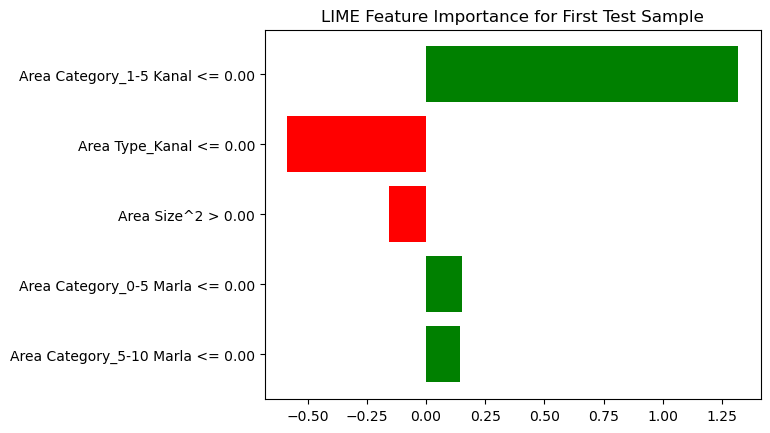


LIME Explanation for Fifth Test Sample:


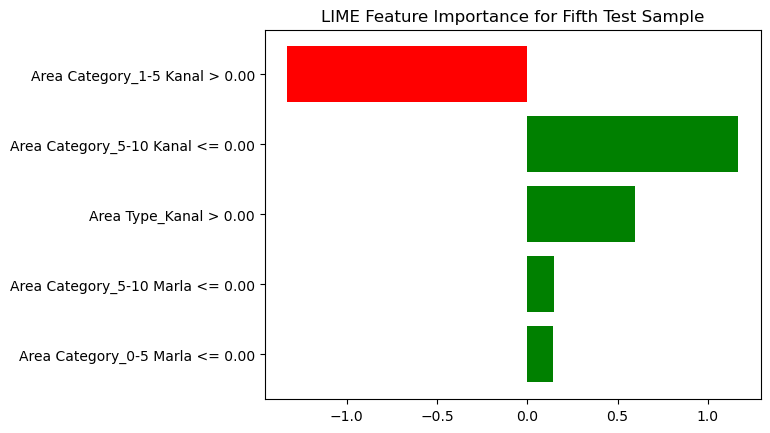

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

np.random.seed(42)

df = df.copy()

# Log-transform the target price
df['price'] = np.log1p(df['price'])

# Remove outliers in the log price
upper_limit = df['price'].quantile(0.975)
lower_limit = df['price'].quantile(0.025)
df = df[(df['price'] < upper_limit) & (df['price'] > lower_limit)]

# 3. Separate features and target
X = df.drop(columns=['price'])
y = df['price']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', MinMaxScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)


print("\nActual vs Predicted Prices (First 10 Samples):")
comparison_df = pd.DataFrame({
    'Actual Price': y_test_real[:10],
    'Predicted Price': y_pred_real[:10],
    'Difference': y_test_real[:10] - y_pred_real[:10]
})
print(comparison_df)


r2 = r2_score(y_test_real, y_pred_real)
print(f"\nR² Score: {r2:.4f}")


# Get preprocessed feature names
num_transformer = model.named_steps['preprocessor'].named_transformers_['num']
poly_feature_names = num_transformer.named_steps['poly'].get_feature_names_out(numeric_features)
cat_transformer = model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = cat_transformer.get_feature_names_out(categorical_features)
feature_names = np.concatenate([poly_feature_names, cat_feature_names])

# Transform training and test data for LIME
X_train_preprocessed = model.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = model.named_steps['preprocessor'].transform(X_test)

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_preprocessed,
    feature_names=feature_names.tolist(),
    mode='regression',
    random_state=42
)

print("\nLIME Explanation for First Test Sample:")
instance = X_test_preprocessed[0]
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.named_steps['regressor'].predict,
    num_features=5  
)
exp.show_in_notebook()  
exp.as_pyplot_figure()  
plt.title("LIME Feature Importance for First Test Sample")
plt.show()


print("\nLIME Explanation for Fifth Test Sample:")
instance = X_test_preprocessed[5]
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.named_steps['regressor'].predict,
    num_features=5
)
exp.as_pyplot_figure()
plt.title("LIME Feature Importance for Fifth Test Sample")
plt.show()

In [18]:
Dpip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8770a56a2f327d0daaf2c85312e604162ec97cbdafb5e72f0e638557a7cf560b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [14]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [8]:
# Step 1: Install the Kaggle API client
!pip install kaggle

# Step 2: Upload the Kaggle API key file (kaggle.json)
from google.colab import files
files.upload()

# Step 3: Set up the Kaggle configuration (the uploaded file will be used)
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Step 4: Download the dataset
!kaggle datasets download -d meerawks/pakistan-property-dataset

# Step 5: Extract the dataset (if it's in a zip file)
!unzip pakistan-property-dataset.zip -d /content/pakistan_property_dataset/


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/meerawks/pakistan-property-dataset
License(s): apache-2.0
Archive:  pakistan-property-dataset.zip
  inflating: /content/pakistan_property_dataset/zameen-property-data.csv  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168446 entries, 0 to 168445
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   property_id    168446 non-null  int64  
 1   location_id    168446 non-null  int64  
 2   page_url       168446 non-null  object 
 3   property_type  168446 non-null  object 
 4   price          168446 non-null  int64  
 5   location       168446 non-null  object 
 6   city           168446 non-null  object 
 7   province_name  168446 non-null  object 
 8   latitude       168446 non-null  float64
 9   longitude      168446 non-null  float64
 10  baths          168446 non-null  int64  
 11  area           168446 non-null  object 
 12  purpose        168446 non-null  object 
 13  bedrooms       168446 non-null  int64  
 14  date_added     168446 non-null  object 
 15  agency         124375 non-null  object 
 16  agent          124374 non-null  object 
 17  Area Type      168446 non-nul

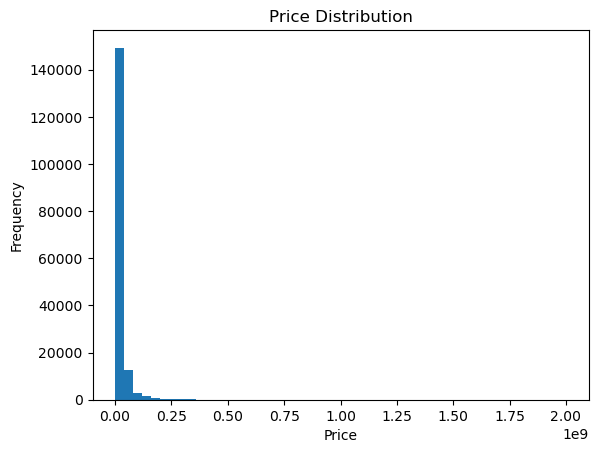

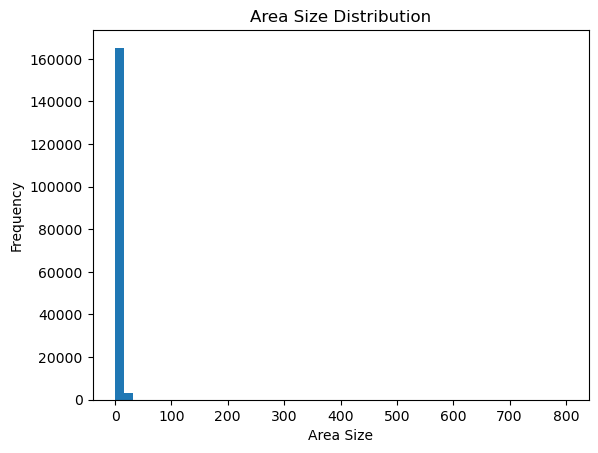

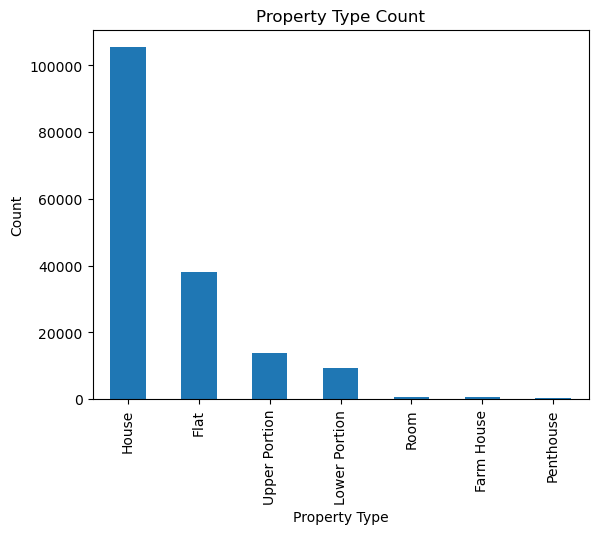

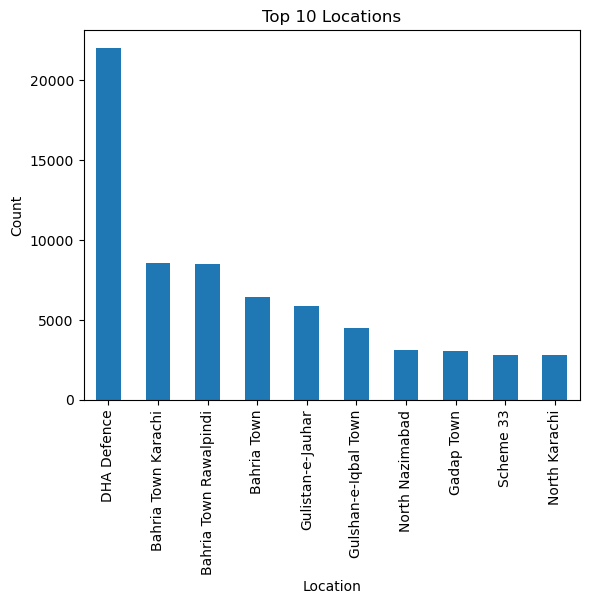

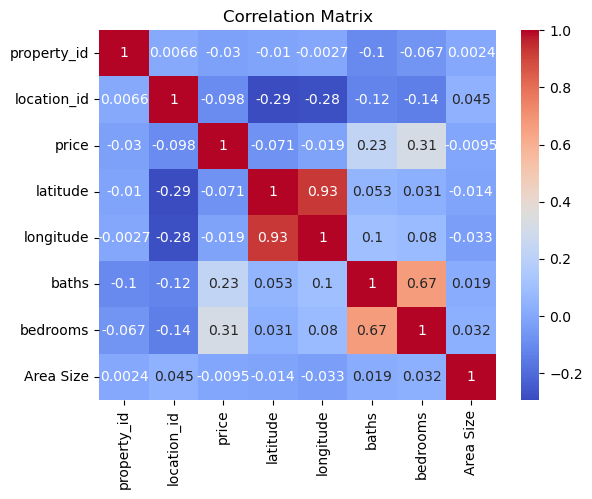

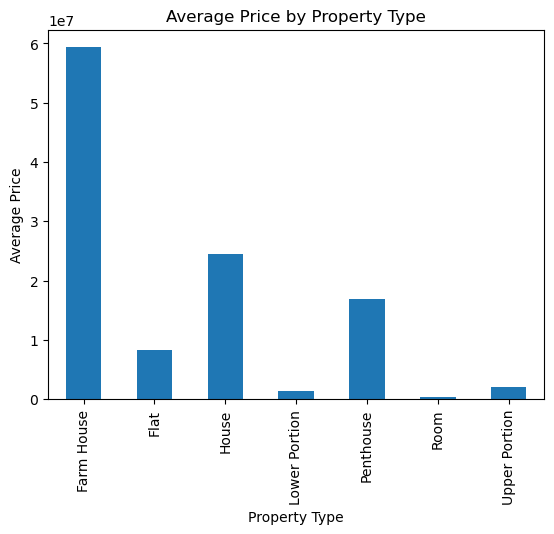

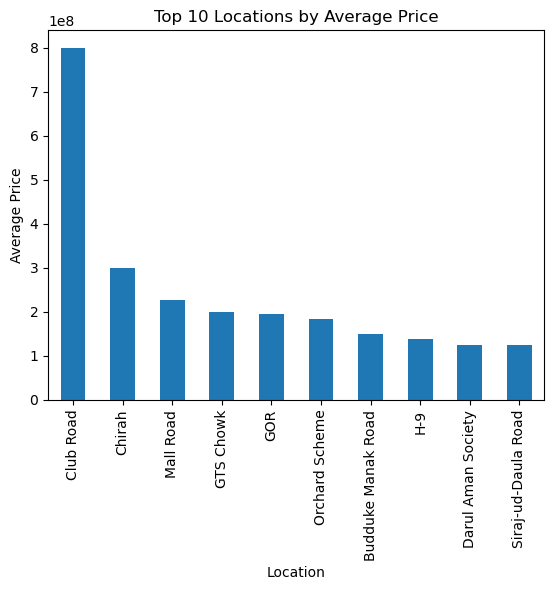

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/zameen-updated.csv')

df.info()

df.describe()

df.isnull().sum()

df['price'].plot(kind='hist', bins=50, title='Price Distribution')
plt.xlabel('Price')
plt.show()

df['Area Size'].plot(kind='hist', bins=50, title='Area Size Distribution')
plt.xlabel('Area Size')
plt.show()

df['property_type'].value_counts().plot(kind='bar', title='Property Type Count')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.show()

df['location'].value_counts().head(10).plot(kind='bar', title='Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

df.groupby('property_type')['price'].mean().plot(kind='bar', title='Average Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Price')
plt.show()

df.groupby('location')['price'].mean().sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Locations by Average Price')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.show()


In [ ]:
# Get correlations with target
target_corr = df[numeric_columns].corr()['price'].abs().sort_values(ascending=False)

# Keep features with correlation > threshold
selected_features = target_corr[target_corr > 0.2].index.tolist()
selected_features.remove('price')  # Remove target variable

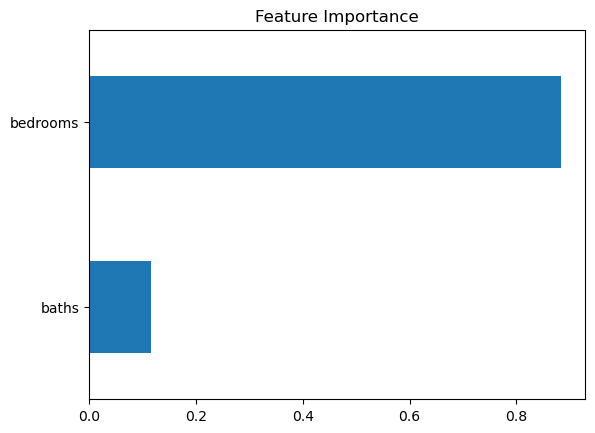

In [25]:
from sklearn.ensemble import RandomForestRegressor

X = df[selected_features]
y = df['price']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Plot feature importance
importances = pd.Series(model.feature_importances_, index=selected_features)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

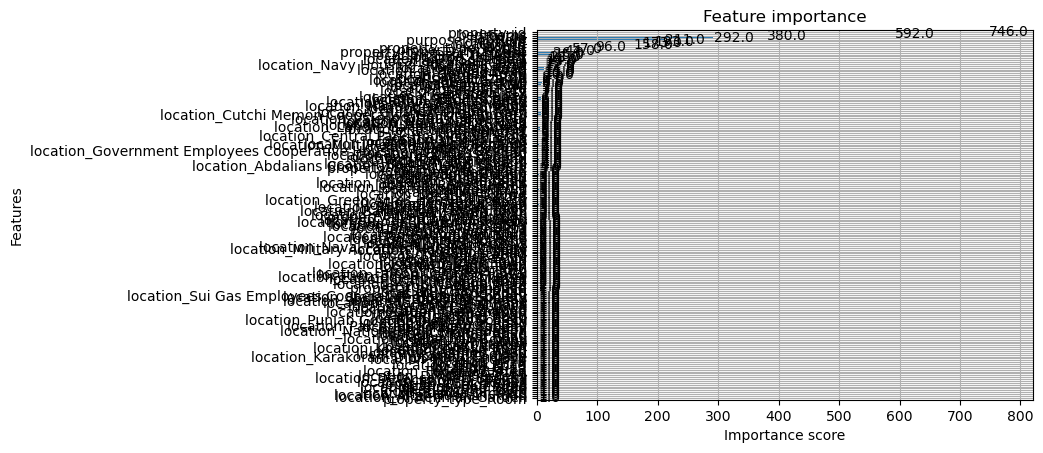

c:\Users\huzai\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\huzai\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [26]:
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

# 1. Select features using correlation (as before)
target_corr = df[numeric_columns].corr()['price'].abs()
selected_features = target_corr[target_corr > 0.2].index.tolist()
selected_features.remove('price')

# 2. Train XGBoost and auto-select features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# 3. Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()

# 4. Refine features (keep top N important)
selector = SelectFromModel(xgb_model, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# 5. Re-train
xgb_model.fit(X_train_selected, y_train)
y_pred = xgb_model.predict(X_test_selected)

In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

# 1. Feature selection (use correlation or XGBoost importance)
selected_features = ['area_sqft', 'bedrooms', 'city_encoded']  # Example

# 2. Reshape for LSTM (samples, timesteps=1, features)
X_train_lstm = X_train[selected_features].values.reshape((X_train.shape[0], 1, len(selected_features)))
X_test_lstm = X_test[selected_features].values.reshape((X_test.shape[0], 1, len(selected_features)))

# 3. Build LSTM
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(1, len(selected_features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 4. Train
history = model.fit(X_train_lstm, y_train, epochs=20, validation_split=0.1)

# 5. Evaluate
y_pred = model.predict(X_test_lstm)

NameError: name 'X_train' is not defined

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('datasets/zameen-updated.csv')

# ----------------------------
# 1. Feature Selection & Preprocessing
# ----------------------------

# Drop irrelevant columns
df = df.drop(['property_id', 'location_id', 'page_url', 'agency', 'agent', 'date_added'], axis=1)

# Define features and target
X = df.drop('price', axis=1)
y = np.log1p(df['price'])  # Log-transform for normalization

# Categorical vs Numerical features
categorical_features = ['property_type', 'location', 'city', 'province_name', 'purpose', 'Area Type', 'Area Category']
numeric_features = ['baths', 'bedrooms', 'latitude', 'longitude', 'Area Size']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# ----------------------------
# 2. Data Preparation
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get input dimension after one-hot encoding
input_dim = X_train_processed.shape[1]

# ----------------------------
# 3. DNN Architecture
# ----------------------------

model = Sequential([
    # Input layer
    Dense(256, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Hidden layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer (linear activation for regression)
    Dense(1)
])

# ----------------------------
# 4. Compile & Train
# ----------------------------

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ----------------------------
# 5. Evaluation
# ----------------------------

# Predict and reverse log-transform
y_pred = model.predict(X_test_processed)
y_pred_real = np.expm1(y_pred.flatten())
y_test_real = np.expm1(y_test)

# Calculate metrics
from sklearn.metrics import r2_score, mean_absolute_error
print(f"R² Score: {r2_score(y_test_real, y_pred_real):.4f}")
print(f"MAE: {mean_absolute_error(y_test_real, y_pred_real):,.2f} PKR")

# ----------------------------
# 6. Feature Importance (Optional)
# ----------------------------

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Plot SHAP values (for interpretation)
import shap
background = X_train_processed[:100]  # Use subset for efficiency
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test_processed[:10])
shap.summary_plot(shap_values, X_test_processed[:10], feature_names=all_feature_names)

c:\Users\huzai\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - loss: 53.1618 - mae: 5.0481 - val_loss: 0.3374 - val_mae: 0.4279
Epoch 2/100
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - loss: 1.6623 - mae: 1.0150 - val_loss: 0.2007 - val_mae: 0.2840
Epoch 3/100
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - loss: 1.3171 - mae: 0.9048 - val_loss: 0.1940 - val_mae: 0.2797
Epoch 4/100
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - loss: 1.2471 - mae: 0.8776 - val_loss: 0.2048 - val_mae: 0.2980
Epoch 5/100
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 77s 23ms/step - loss: 1.1948 - mae: 0.8580 - val_loss: 0.1719 - val_mae: 0.2496
Epoch 6/100
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 85s 25ms/step - loss: 1.1583 - mae: 0.8440 - val_loss: 0.1897 - val_mae: 0.2692
Epoch 7/100
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - loss: 1.1098 - mae: 0.8250 - val_loss: 0.1756 - val_mae: 0.2583
Epoch 8/100
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - loss: 1.1040 - mae: 0.8192 - val_loss: 0.1890 - val_mae: 0.2829
Epoch 9/100
336

ModuleNotFoundError: No module named 'shap'

In [17]:
import pandas as pd
import numpy as np

try:
    df1 = pd.read_csv('datasets/zameen-updated.csv')
    df2 = pd.read_csv('datasets/zameen-property-data.csv')

    print("Dataset 1 shape:", df1.shape)
    print("Dataset 2 shape:", df2.shape)

    merged_df = pd.concat([df1, df2], ignore_index=True)

    merged_df.drop_duplicates(subset=['property_id'], keep='last', inplace=True)

    numeric_cols = ['price', 'latitude', 'longitude', 'baths', 'bedrooms', 'Area Size']
    for col in numeric_cols:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

    merged_df['price'].fillna(merged_df['price'].median(), inplace=True)
    merged_df['latitude'].fillna(merged_df['latitude'].mean(), inplace=True)
    merged_df['longitude'].fillna(merged_df['longitude'].mean(), inplace=True)
    merged_df['baths'].fillna(merged_df['baths'].median(), inplace=True)
    merged_df['bedrooms'].fillna(merged_df['bedrooms'].median(), inplace=True)
    merged_df['Area Size'].fillna(merged_df['Area Size'].median(), inplace=True)

    merged_df['agency'].fillna('Unknown', inplace=True)
    merged_df['agent'].fillna('Unknown', inplace=True)

    merged_df['date_added'] = pd.to_datetime(merged_df['date_added'], errors='coerce')

    categorical_columns = ['property_type', 'location', 'city', 'province_name',
                         'purpose', 'Area Type', 'Area Category']
    merged_df = pd.get_dummies(merged_df, columns=categorical_columns)

    merged_df.drop(['page_url'], axis=1, inplace=True)

    merged_df.reset_index(drop=True, inplace=True)

    print("Merged Dataset Info:")
    print(merged_df.info())
    print("\nFirst 5 Rows:")
    print(merged_df.head())
    print("\nShape:", merged_df.shape)

except FileNotFoundError:
    print("Error: One or both CSV files not found. Please check file paths.")
except Exception as e:
    print(f"Error occurred: {str(e)}")

Dataset 1 shape: (168446, 20)
Dataset 2 shape: (168446, 17)


C:\Users\huzai\AppData\Local\Temp\ipykernel_15132\2101045851.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['price'].fillna(merged_df['price'].median(), inplace=True)
C:\Users\huzai\AppData\Local\Temp\ipykernel_15132\2101045851.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168446 entries, 0 to 168445
Columns: 1538 entries, property_id to purpose_For Sale
dtypes: bool(1526), datetime64[ns](1), float64(3), int64(5), object(3)
memory usage: 260.6+ MB
None

First 5 Rows:
   property_id  location_id     price   latitude  longitude  baths       area  \
0       237062         3325  10000000  33.679890  73.012640      2    4 Marla   
1       346905         3236   6900000  33.700993  72.971492      3  5.6 Marla   
2       386513          764  16500000  33.631486  72.926559      6    8 Marla   
3       656161          340  43500000  33.707573  73.151199      4    2 Kanal   
4       841645         3226   7000000  33.492591  73.301339      3    8 Marla   

   bedrooms date_added         agency  ... city_Faisalabad  city_Islamabad  \
0         2 2019-02-04        Unknown  ...           False            True   
1         3 2019-05-04        Unknown  ...           False            True   
2         

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming merged_df is already created from previous code
# If not, you would need to run the previous merge code first

# 1. Separate features and target
X = merged_df.drop(['price'], axis=1)  # Input features
y = merged_df['price']  # Target variable

# 2. Handle datetime column
X['year'] = X['date_added'].dt.year.fillna(0).astype(int)
X['month'] = X['date_added'].dt.month.fillna(0).astype(int)
X = X.drop(['date_added'], axis=1)

# 3. Convert object columns to numeric where possible
for col in X.select_dtypes(include=['object']).columns:
    if col not in ['agency', 'agent', 'area']:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# 4. Drop non-numeric columns that can't be used in prediction
X = X.drop(['agency', 'agent', 'area'], axis=1)

# 5. Handle remaining missing values
X = X.fillna(X.median(numeric_only=True))
y = y.fillna(y.median())

# 6. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Standardization (zero mean, unit variance)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Transform test data
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# 8. Normalization (scale to 0-1 range)
normalizer_X = MinMaxScaler()
normalizer_y = MinMaxScaler()

# Fit and transform training data
X_train_normalized = normalizer_X.fit_transform(X_train)
y_train_normalized = normalizer_y.fit_transform(y_train.values.reshape(-1, 1))

# Transform test data
X_test_normalized = normalizer_X.transform(X_test)
y_test_normalized = normalizer_y.transform(y_test.values.reshape(-1, 1))

# 9.
print("Training set shape (scaled):", X_train_scaled.shape)
print("Test set shape (scaled):", X_test_scaled.shape)
print("Training set shape (normalized):", X_train_normalized.shape)
print("Test set shape (normalized):", X_test_normalized.shape)

print("\nSample of scaled features (first 5 rows, first 5 columns):")
print(X_train_scaled[:5, :5])
print("\nSample of normalized features (first 5 rows, first 5 columns):")
print(X_train_normalized[:5, :5])

print("\nSample of scaled target (first 5 values):")
print(y_train_scaled[:5].flatten())
print("\nSample of normalized target (first 5 values):")
print(y_train_normalized[:5].flatten())

# 10.
np.save('X_train_scaled.npy', X_train_scaled)
np.save('X_test_scaled.npy', X_test_scaled)
np.save('y_train_scaled.npy', y_train_scaled)
np.save('y_test_scaled.npy', y_test_scaled)

np.save('X_train_normalized.npy', X_train_normalized)
np.save('X_test_normalized.npy', X_test_normalized)
np.save('y_train_normalized.npy', y_train_normalized)
np.save('y_test_normalized.npy', y_test_normalized)

import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
joblib.dump(normalizer_X, 'normalizer_X.pkl')
joblib.dump(normalizer_y, 'normalizer_y.pkl')

c:\Users\huzai\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\huzai\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\huzai\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\huzai\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:701: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\huzai\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:718: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Training set shape (scaled): (134756, 1535)
Test set shape (scaled): (33690, 1535)
Training set shape (normalized): (134756, 1535)
Test set shape (normalized): (33690, 1535)

Sample of scaled features (first 5 rows, first 5 columns):
[[-0.10360804  0.75448002 -1.28731299 -1.33363246 -1.1443708 ]
 [ 0.5787902  -0.27049211  0.99061446  0.54110681  1.64080544]
 [-0.54214936  1.01979185  0.94937092  0.58381829 -1.1443708 ]
 [ 0.71935017 -0.27393428  0.99547885  0.54992289  0.8450408 ]
 [ 0.31872448  0.75395046 -1.28907899 -1.33549648 -0.34860616]]

Sample of normalized features (first 5 rows, first 5 columns):
[[0.88419898 0.50784162 0.00410968 0.68032533 0.        ]
 [0.97325985 0.23560025 0.18339118 0.82353674 0.01736973]
 [0.82696426 0.57831071 0.18014516 0.82679948 0.        ]
 [0.99160455 0.23468598 0.18377403 0.8242102  0.01240695]
 [0.93931826 0.50770096 0.00397069 0.68018293 0.00496278]]

Sample of scaled target (first 5 values):
[ 0.2583013   0.70750141 -0.43795886  0.30041381 -0.

['normalizer_y.pkl']

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
import joblib

# Load preprocessed data (assuming saved from previous step)
X_train_scaled = np.load('X_train_scaled.npy')
X_test_scaled = np.load('X_test_scaled.npy')
y_train_scaled = np.load('y_train_scaled.npy')
y_test_scaled = np.load('y_test_scaled.npy')

# Load scalers to inverse transform predictions
scaler_y = joblib.load('scaler_y.pkl')

# Flatten y arrays if needed
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

# Initialize XGBoost regressor with optimized parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_train_pred_scaled = xgb_model.predict(X_train_scaled)
y_test_pred_scaled = xgb_model.predict(X_test_scaled)

# Inverse transform predictions and actual values to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_train_orig = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Calculate R² scores
r2_train = r2_score(y_train_orig, y_train_pred)
r2_test = r2_score(y_test_orig, y_test_pred)

# Print results
print("Model Performance:")
print(f"R² Score (Training): {r2_train:.4f}")
print(f"R² Score (Testing): {r2_test:.4f}")

# Feature importance (optional)
feature_importance = xgb_model.feature_importances_
feature_names = [f"feature_{i}" for i in range(X_train_scaled.shape[1])]  # Placeholder names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Save the trained model
joblib.dump(xgb_model, 'xgb_property_price_model.pkl')

# Example prediction for a single test sample
sample_idx = 0
sample_pred_scaled = y_test_pred_scaled[sample_idx]
sample_pred = y_test_pred[sample_idx]
sample_actual = y_test_orig[sample_idx]

print(f"\nExample Prediction (Sample {sample_idx}):")
print(f"Predicted Price (scaled): {sample_pred_scaled:.4f}")
print(f"Predicted Price (original): {sample_pred:,.0f}")
print(f"Actual Price: {sample_actual:,.0f}")

Model Performance:
R² Score (Training): 0.8392
R² Score (Testing): 0.6459

Top 10 Most Important Features:
           Feature  Importance
1525  feature_1525    0.133827
365    feature_365    0.060780
242    feature_242    0.037162
929    feature_929    0.036515
1529  feature_1529    0.036352
461    feature_461    0.029907
978    feature_978    0.022646
576    feature_576    0.021785
768    feature_768    0.021706
1531  feature_1531    0.020358

Example Prediction (Sample 0):
Predicted Price (scaled): 3.9980
Predicted Price (original): 160,202,912
Actual Price: 87,500,000


=== Debugging Property Price Prediction ===

1. Data Shape Check:
X_train_scaled shape: (134756, 1535)
X_test_scaled shape: (33690, 1535)
y_train_scaled shape: (134756,)
y_test_scaled shape: (33690,)

2. Target Distribution Analysis:
Training Set Stats:
count    1.347560e+05
mean     1.779960e+07
std      3.561900e+07
min      0.000000e+00
25%      1.750000e+05
50%      8.500000e+06
75%      1.950000e+07
max      2.000000e+09
dtype: float64

Testing Set Stats:
count    3.369000e+04
mean     1.763040e+07
std      3.404634e+07
min      0.000000e+00
25%      1.800000e+05
50%      8.500000e+06
75%      1.950000e+07
max      1.250000e+09
dtype: float64
Skewness of Training Target: 9.6403
Issue: Target is highly skewed. Consider log transformation.


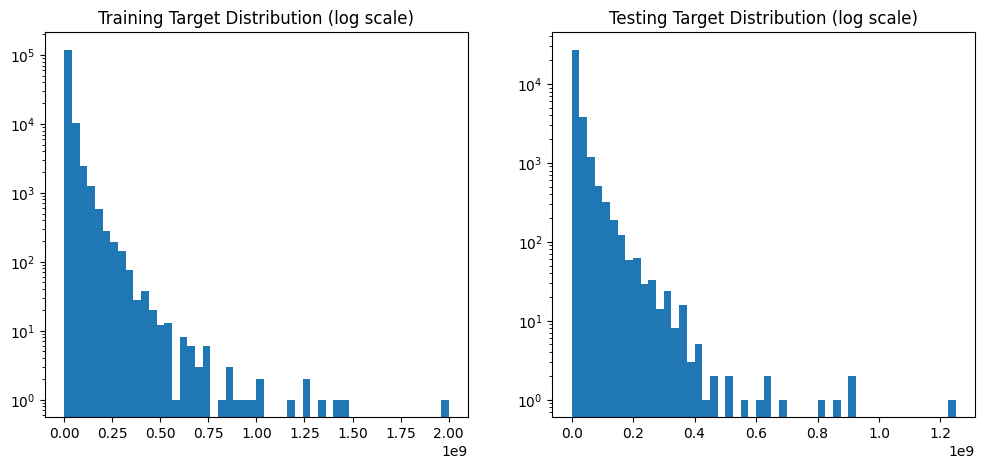


3. NaN and Infinite Values Check:
X_train_scaled NaN count: 134756
X_test_scaled NaN count: 33690
y_train_scaled NaN count: 0
y_test_scaled NaN count: 0
X_train_scaled Inf count: 0
X_test_scaled Inf count: 0
Issue: NaN values present in data. Preprocessing failed to handle all missing values.

4. Feature Variance Analysis:
Number of features with zero variance: 42
Issue: Features with zero variance detected. These are useless for prediction.

5. Model Performance Metrics:
Training Set:
R²: 0.8368
MSE: 207,038,853,278,900
MAE: 5,459,217
Testing Set:
R²: 0.6459
MSE: 410,471,161,603,756
MAE: 6,313,334
Issue: Significant gap between train and test R². Possible overfitting.
Issue: Low test R². Model is not generalizing well.


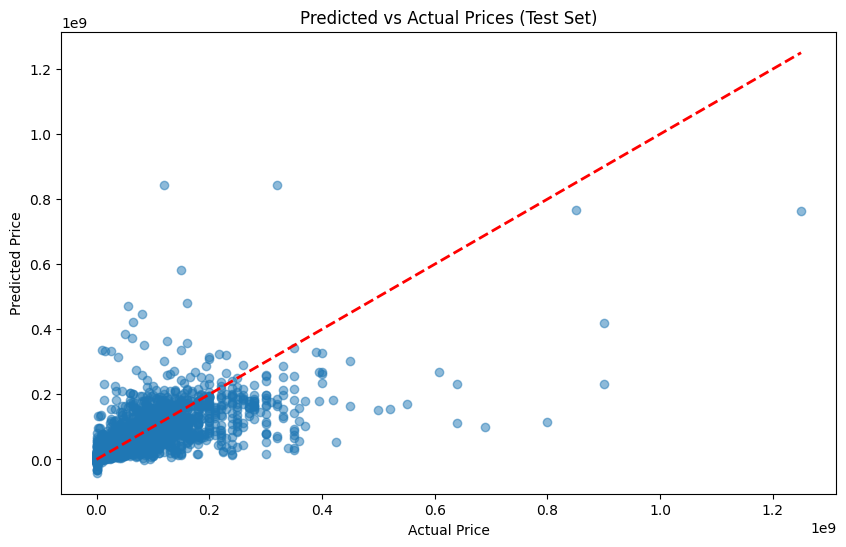


6. Feature Importance Analysis:
           Feature  Importance
1525  feature_1525    0.112505
1529  feature_1529    0.049921
365    feature_365    0.043325
461    feature_461    0.034006
929    feature_929    0.032848
242    feature_242    0.024048
576    feature_576    0.023647
978    feature_978    0.023532
1531  feature_1531    0.022865
1526  feature_1526    0.020324

7. Outlier Analysis:
Number of outliers in training set: 15075
Number of outliers in testing set: 3443
Issue: High proportion of outliers in test set. Model struggles with extreme values.

8. Sample Predictions (First 5 Test Samples):
Sample 0:
Predicted: 160,056,736
Actual: 87,500,000
Difference: 72,556,736
Sample 1:
Predicted: 7,648,834
Actual: 55,000
Difference: 7,593,834
Sample 2:
Predicted: 22,690,014
Actual: 21,800,000
Difference: 890,014
Sample 3:
Predicted: 13,051,994
Actual: 6,500,000
Difference: 6,551,994
Sample 4:
Predicted: -1,622,460
Actual: 75,000
Difference: 1,697,460

9. Summary of Possible Issues:
- L

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# Load preprocessed data
X_train_scaled = np.load('X_train_scaled.npy')
X_test_scaled = np.load('X_test_scaled.npy')
y_train_scaled = np.load('y_train_scaled.npy')
y_test_scaled = np.load('y_test_scaled.npy')
scaler_y = joblib.load('scaler_y.pkl')

# Flatten y arrays
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

# Inverse transform to original scale
y_train_orig = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Debugging Function
def debug_property_price_prediction():
    print("=== Debugging Property Price Prediction ===")

    # 1. Data Shape and Basic Stats
    print("\n1. Data Shape Check:")
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")
    print(f"y_train_scaled shape: {y_train_scaled.shape}")
    print(f"y_test_scaled shape: {y_test_scaled.shape}")

    # 2. Target Distribution
    print("\n2. Target Distribution Analysis:")
    train_stats = pd.Series(y_train_orig).describe()
    test_stats = pd.Series(y_test_orig).describe()
    print("Training Set Stats:")
    print(train_stats)
    print("\nTesting Set Stats:")
    print(test_stats)
    skewness = pd.Series(y_train_orig).skew()
    print(f"Skewness of Training Target: {skewness:.4f}")
    if skewness > 1 or skewness < -1:
        print("Issue: Target is highly skewed. Consider log transformation.")

    # Plot distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(y_train_orig, bins=50, log=True)
    plt.title("Training Target Distribution (log scale)")
    plt.subplot(1, 2, 2)
    plt.hist(y_test_orig, bins=50, log=True)
    plt.title("Testing Target Distribution (log scale)")
    plt.show()

    # 3. NaN and Infinite Values
    print("\n3. NaN and Infinite Values Check:")
    nan_train_x = np.isnan(X_train_scaled).sum()
    nan_test_x = np.isnan(X_test_scaled).sum()
    nan_train_y = np.isnan(y_train_scaled).sum()
    nan_test_y = np.isnan(y_test_scaled).sum()
    inf_train_x = np.isinf(X_train_scaled).sum()
    inf_test_x = np.isinf(X_test_scaled).sum()

    print(f"X_train_scaled NaN count: {nan_train_x}")
    print(f"X_test_scaled NaN count: {nan_test_x}")
    print(f"y_train_scaled NaN count: {nan_train_y}")
    print(f"y_test_scaled NaN count: {nan_test_y}")
    print(f"X_train_scaled Inf count: {inf_train_x}")
    print(f"X_test_scaled Inf count: {inf_test_x}")

    if nan_train_x > 0 or nan_test_x > 0 or nan_train_y > 0 or nan_test_y > 0:
        print("Issue: NaN values present in data. Preprocessing failed to handle all missing values.")
    if inf_train_x > 0 or inf_test_x > 0:
        print("Issue: Infinite values present in features. Check scaling process.")

    # 4. Feature Variance
    print("\n4. Feature Variance Analysis:")
    feature_variance = np.var(X_train_scaled, axis=0)
    zero_variance_count = (feature_variance == 0).sum()
    print(f"Number of features with zero variance: {zero_variance_count}")
    if zero_variance_count > 0:
        print("Issue: Features with zero variance detected. These are useless for prediction.")

    # 5. Train Model
    xgb_model = xgb.XGBRegressor(
        n_estimators=1000, max_depth=7, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train_scaled)

    # 6. Predictions and Metrics
    y_train_pred_scaled = xgb_model.predict(X_train_scaled)
    y_test_pred_scaled = xgb_model.predict(X_test_scaled)

    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

    print("\n5. Model Performance Metrics:")
    r2_train = r2_score(y_train_orig, y_train_pred)
    r2_test = r2_score(y_test_orig, y_test_pred)
    mse_train = mean_squared_error(y_train_orig, y_train_pred)
    mse_test = mean_squared_error(y_test_orig, y_test_pred)
    mae_train = mean_absolute_error(y_train_orig, y_train_pred)
    mae_test = mean_absolute_error(y_test_orig, y_test_pred)

    print("Training Set:")
    print(f"R²: {r2_train:.4f}")
    print(f"MSE: {mse_train:,.0f}")
    print(f"MAE: {mae_train:,.0f}")
    print("Testing Set:")
    print(f"R²: {r2_test:.4f}")
    print(f"MSE: {mse_test:,.0f}")
    print(f"MAE: {mae_test:,.0f}")

    if r2_train - r2_test > 0.1:
        print("Issue: Significant gap between train and test R². Possible overfitting.")
    if r2_test < 0.7:
        print("Issue: Low test R². Model is not generalizing well.")

    # 7. Prediction vs Actual Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_orig, y_test_pred, alpha=0.5)
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Predicted vs Actual Prices (Test Set)")
    plt.show()

    # 8. Feature Importance
    print("\n6. Feature Importance Analysis:")
    feature_importance = xgb_model.feature_importances_
    feature_names = [f"feature_{i}" for i in range(X_train_scaled.shape[1])]
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    print(importance_df.head(10))

    if importance_df['Importance'].iloc[0] < 0.05:
        print("Issue: No single feature has strong importance. Features may not be predictive.")

    # 9. Outlier Check
    print("\n7. Outlier Analysis:")
    outliers_train = np.abs(y_train_orig - y_train_pred) > 2 * mae_train
    outliers_test = np.abs(y_test_orig - y_test_pred) > 2 * mae_test
    print(f"Number of outliers in training set: {outliers_train.sum()}")
    print(f"Number of outliers in testing set: {outliers_test.sum()}")
    if outliers_test.sum() / len(y_test_orig) > 0.1:
        print("Issue: High proportion of outliers in test set. Model struggles with extreme values.")

    # 10. Sample Predictions
    print("\n8. Sample Predictions (First 5 Test Samples):")
    for i in range(5):
        print(f"Sample {i}:")
        print(f"Predicted: {y_test_pred[i]:,.0f}")
        print(f"Actual: {y_test_orig[i]:,.0f}")
        print(f"Difference: {abs(y_test_pred[i] - y_test_orig[i]):,.0f}")

    # 11. Possible Issues Summary
    print("\n9. Summary of Possible Issues:")
    if r2_test < 0.7:
        print("- Low R²: Model may not capture the data's patterns well.")
    if r2_train - r2_test > 0.1:
        print("- Overfitting: Model performs much better on training than testing.")
    if skewness > 1 or skewness < -1:
        print("- Skewed Target: Highly skewed prices may need transformation (e.g., log).")
    if nan_train_x > 0 or nan_test_x > 0 or nan_train_y > 0 or nan_test_y > 0:
        print("- NaN Values: Missing data not fully handled.")
    if zero_variance_count > 0:
        print("- Zero Variance Features: Some features provide no information.")
    if importance_df['Importance'].iloc[0] < 0.05:
        print("- Weak Features: Features may not be strongly predictive.")
    if outliers_test.sum() / len(y_test_orig) > 0.1:
        print("- Outliers: Model fails to predict extreme values accurately.")
    if mse_test > mse_train * 2:
        print("- High Test Error: Large errors on test set indicate poor generalization.")

# Run the debugging
debug_property_price_prediction()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
import joblib

df1 = pd.read_csv('datasets/zameen-updated.csv')
df2 = pd.read_csv('datasets/zameen-property-data.csv')

merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df = merged_df.drop_duplicates(subset=['property_id'], keep='last')

numeric_cols = ['price', 'latitude', 'longitude', 'baths', 'bedrooms', 'Area Size']
for col in numeric_cols:
    merged_df.loc[:, col] = pd.to_numeric(merged_df[col], errors='coerce')

merged_df = merged_df.assign(
    price=merged_df['price'].fillna(merged_df['price'].median()),
    latitude=merged_df['latitude'].fillna(merged_df['latitude'].mean()),
    longitude=merged_df['longitude'].fillna(merged_df['longitude'].mean()),
    baths=merged_df['baths'].fillna(merged_df['baths'].median()),
    bedrooms=merged_df['bedrooms'].fillna(merged_df['bedrooms'].median()),
    Area_Size=merged_df['Area Size'].fillna(merged_df['Area Size'].median()),
    agency=merged_df['agency'].fillna('Unknown'),
    agent=merged_df['agent'].fillna('Unknown')
)

merged_df['date_added'] = pd.to_datetime(merged_df['date_added'], errors='coerce')
categorical_columns = ['property_type', 'location', 'city', 'province_name', 'purpose', 'Area Type', 'Area Category']
merged_df = pd.get_dummies(merged_df, columns=categorical_columns)
merged_df = merged_df.drop(['page_url'], axis=1)
merged_df = merged_df.reset_index(drop=True)

X = merged_df.drop(['price'], axis=1)
y = merged_df['price']

X['year'] = X['date_added'].dt.year.fillna(0).astype(int)
X['month'] = X['date_added'].dt.month.fillna(0).astype(int)
X = X.drop(['date_added'], axis=1)

X = X.drop(['agency', 'agent', 'area'], axis=1)

X = X.astype(float)

X = X.fillna(X.median().fillna(0))
y = y.fillna(y.median())

y = np.log1p(y)

X = X.dropna()
y = y.loc[X.index]

selector = VarianceThreshold(threshold=0.0)
X = selector.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_train_scaled = np.nan_to_num(X_train_scaled, nan=0)
y_train_scaled = np.nan_to_num(y_train_scaled, nan=0)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_test_scaled = np.nan_to_num(X_test_scaled, nan=0)
y_test_scaled = np.nan_to_num(y_test_scaled, nan=0)

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=1.0,
    reg_alpha=0.1,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='rmse'
)

xgb_model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_test_scaled, y_test_scaled)],
    verbose=False
)

y_train_pred_scaled = xgb_model.predict(X_train_scaled)
y_test_pred_scaled = xgb_model.predict(X_test_scaled)

y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_train_orig = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

y_train_pred = np.expm1(y_train_pred)
y_test_pred = np.expm1(y_test_pred)
y_train_orig = np.expm1(y_train_orig)
y_test_orig = np.expm1(y_test_orig)

r2_train = r2_score(y_train_orig, y_train_pred)
r2_test = r2_score(y_test_orig, y_test_pred)

print("Model Performance:")
print(f"R² Score (Training): {r2_train:.4f}")
print(f"R² Score (Testing): {r2_test:.4f}")

cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train_scaled, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Average CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

feature_importance = xgb_model.feature_importances_
feature_names = [f"feature_{i}" for i in range(X_train_scaled.shape[1])]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

joblib.dump(xgb_model, 'xgb_property_price_model_improved.pkl')
joblib.dump(scaler_X, 'scaler_X_improved.pkl')
joblib.dump(scaler_y, 'scaler_y_improved.pkl')

Model Performance:
R² Score (Training): 0.6167
R² Score (Testing): 0.6131
